In [1]:
import torch
import torch.nn as nn
import numpy
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from datetime import datetime
import os, sys
from glob import glob
import imageio
import numpy as np

In [2]:
!unzip Food-5K.zip

Archive:  Food-5K.zip
replace evaluation/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
!unzip -qq -o Food-5K.zip

^C


In [4]:
!ls training/

0_0.jpg    0_1384.jpg 0_420.jpg  0_807.jpg  1_1192.jpg 1_229.jpg  1_615.jpg
0_1.jpg    0_1385.jpg 0_421.jpg  0_808.jpg  1_1193.jpg 1_23.jpg   1_616.jpg
0_10.jpg   0_1386.jpg 0_422.jpg  0_809.jpg  1_1194.jpg 1_230.jpg  1_617.jpg
0_100.jpg  0_1387.jpg 0_423.jpg  0_81.jpg   1_1195.jpg 1_231.jpg  1_618.jpg
0_1000.jpg 0_1388.jpg 0_424.jpg  0_810.jpg  1_1196.jpg 1_232.jpg  1_619.jpg
0_1001.jpg 0_1389.jpg 0_425.jpg  0_811.jpg  1_1197.jpg 1_233.jpg  1_62.jpg
0_1002.jpg 0_139.jpg  0_426.jpg  0_812.jpg  1_1198.jpg 1_234.jpg  1_620.jpg
0_1003.jpg 0_1390.jpg 0_427.jpg  0_813.jpg  1_1199.jpg 1_235.jpg  1_621.jpg
0_1004.jpg 0_1391.jpg 0_428.jpg  0_814.jpg  1_12.jpg   1_236.jpg  1_622.jpg
0_1005.jpg 0_1392.jpg 0_429.jpg  0_815.jpg  1_120.jpg  1_237.jpg  1_623.jpg
0_1006.jpg 0_1393.jpg 0_43.jpg   0_816.jpg  1_1200.jpg 1_238.jpg  1_624.jpg
0_1007.jpg 0_1394.jpg 0_430.jpg  0_817.jpg  1_1201.jpg 1_239.jpg  1_625.jpg
0_1008.jpg 0_1395.jpg 0_431.jpg  0_818.jpg  1_1202.jpg 1_24.jpg   1_626.jpg
0_1009.jpg 0_

/var/folders/tr/96x2fhf966z17tmtzx0bls5h0000gn/T/ipykernel_3393/6103573.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('data_food/train/nonfood/0_1180.jpg'))


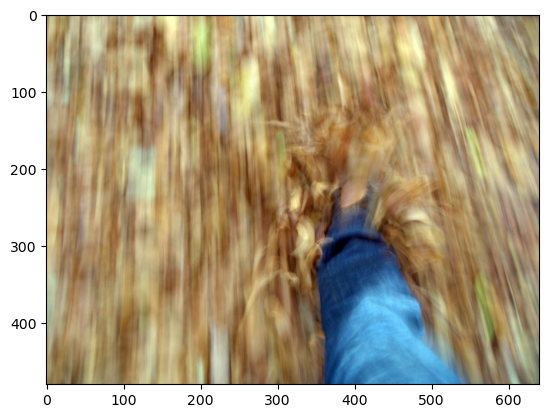

In [5]:
plt.imshow(imageio.imread('data_food/train/nonfood/0_1180.jpg'))
plt.show()

/var/folders/tr/96x2fhf966z17tmtzx0bls5h0000gn/T/ipykernel_3393/1363874290.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('training/1_616.jpg'))


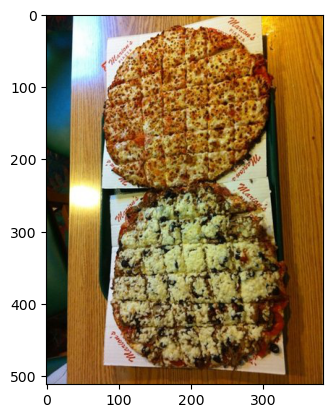

In [6]:
#Food images start with 1, non-food images start with 0
plt.imshow(imageio.imread('training/1_616.jpg'))
plt.show()

In [7]:
!mkdir data_food

mkdir: data_food: File exists


In [8]:
#Make directories to store the data Keras-Style
!mkdir data_food/train
!mkdir data_food/test
!mkdir data_food/train/nonfood
!mkdir data_food/train/food
!mkdir data_food/test/nonfood
!mkdir data_food/test/food

mkdir: data_food/train: File exists
mkdir: data_food/test: File exists
mkdir: data_food/train/nonfood: File exists
mkdir: data_food/train/food: File exists
mkdir: data_food/test/nonfood: File exists
mkdir: data_food/test/food: File exists


In [9]:
#Move the images
#Note: we will consider 'training' to be the train set
#'validation' folder will be the test set
#ignore the 'evaluation' set
!mv training/0*.jpg data_food/train/nonfood
!mv training/1*.jpg data_food/train/food
!mv validation/0*.jpg data_food/test/nonfood
!mv validation/1*.jpg data_food/test/food

In [10]:
#note: normalize mean and std are standardized for imageNet
#https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/image
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [11]:
#create train and test dataset
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

train_dataset = CustomImageFolder(
    'data_food/train',
    transform=train_transform
)
test_dataset = CustomImageFolder(
    'data_food/test',
    transform=test_transform
)

In [12]:
train_dataset, test_dataset

(Dataset CustomImageFolder
     Number of datapoints: 3003
     Root location: data_food/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset CustomImageFolder
     Number of datapoints: 1000
     Root location: data_food/test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.48

In [13]:
type(train_dataset)

__main__.CustomImageFolder

In [14]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [15]:
#Define the model
model = models.vgg16(pretrained=True)

/Users/mikkychilaka/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mikkychilaka/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
#freeze vgg weights
for param in model.parameters():
    param.requires_grad = False
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [18]:
n_features = model.classifier[0].in_features
n_features

25088

In [19]:
model.classifier = nn.Linear(n_features, 2)

In [20]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
import numpy as np
from datetime import datetime
import torch
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_loss = []
    model.train()
    t0 = datetime.now()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device) , targets.to(device)
        #zero the parameters
        optimizer.zero_grad()
        #forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        #backward and optimize
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    #test loss
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        test_loss.append(loss.item)
    test_loss = np.mean(test_loss)
    
print(f'Epochs {it+1} , Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}, duration : {dt}')

In [24]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs = 5
)


KeyboardInterrupt



In [ ]:
#Plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label= 'test loss')
plt.legend()
plt.show()

In [ ]:
#Accuracy
n_correct = 0 
n_total = 0
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    #Forward pass
    outputs = model(inputs)
    #get prediction
    #torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    #update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), outputs.to(device)
    #forward pass
    outputs = model(inputs)
    #get prediction
    _, predictions = torch.max(outputs, 1)
    #update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cpu')

In [27]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1